# Quantized inverse dynamic for  Go -Explore

In [46]:
import numpy as np

import gym
import gym_robotics
from stable_baselines3 import SAC
from lge.lge import LatentGoExplore

env = gym.make("__root__/FetchNoTask-v1", image_obs_space=False)

lge = LatentGoExplore(
    SAC,
    env,
    traj_step=10,
    latent_size=16,
    distance_threshold=0.2,
    model_kwargs=dict(buffer_size=40_000),
    verbose=1,
)

Using cpu device


In [47]:
n = 40_000
lge.explore(n)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 769      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 869      |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 12       |
|    fps      

Sample goals and trajectories. Draw them and store the image into `goals_and_traj.bmp`.

In [48]:
lge.archive.recompute_embeddings()

Display the 10 less dense observations.

In [20]:
from PIL import Image
from IPython.display import display

archive = lge.archive
idxs = archive.sorted_density[:10]
observations = archive.next_observations["observation"][idxs, 0]
img = Image.fromarray(np.hstack(np.moveaxis(observations, -3, -1)))
display(img)


AxisError: source: axis -3 is out of bounds for array of dimension 2

Render the latent space and the observation space to see the cells.

In [49]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap()

embeddings = lge.archive.next_embeddings[:n].reshape(n, -1)
density = lge.archive.density
sorted_density = lge.archive.sorted_density
l_density = (density < np.quantile(density, 0.10)).astype(float)

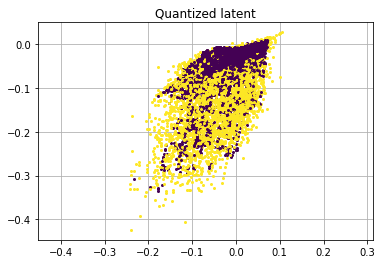

In [50]:
fig, axs = plt.subplots(1, 1)

# Quantized latent
axs.grid()
axs.set_title("Quantized latent")
axs.axis("equal")
for i in range(n):
    axs.plot(*embeddings[:, 6:8][i].T, "o", c=cmap(l_density[i]), markersize=2)


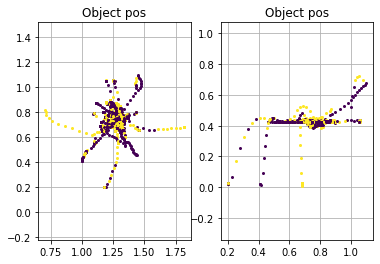

In [51]:
idx = lge.archive.sorted_density[:20]
# 0, 1, 2    = gripper_pos
# 3, 4       = gripper_width
# 5, 6, 7    = gripper_vel
# 8, 9, 10   = object_pos
# 11, 12, 13 = object_rot
# 14, 15, 16 = object_velp
# 17, 18, 19 = object_velr

fig, axs = plt.subplots(1, 2)

# Quantized latent
axs[0].grid()
axs[0].set_title("Object pos")
axs[0].axis("equal")
axs[1].grid()
axs[1].set_title("Object pos")
axs[1].axis("equal")

for i in range(n):
    axs[0].plot(*lge.archive.next_observations["observation"][i, 0, 8:10].T, "o", c=cmap(l_density[i]), markersize=2)
    axs[1].plot(*lge.archive.next_observations["observation"][i, 0, 9:11].T, "o", c=cmap(l_density[i]), markersize=2)


In [52]:
print(lge.archive.next_observations["observation"][:, 0, 10].max())

0.7217249


Test wether the inverse model is accurate.

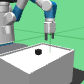

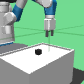

true action		 tensor([[-0.3094,  0.2850,  0.9634, -0.8120]])
predicted action	 tensor([[-0.0734,  0.3593,  1.0768, -0.1395]], grad_fn=<AddmmBackward0>)


In [ ]:
# Sample one transition
sample = go_explore.archive.sample(1)
observations = sample.observations["observation"] / 255
next_observations = sample.next_observations["observation"] / 255
actions = sample.actions

# Predict the action
go_explore.archive.inverse_model.eval()
pred_actions = go_explore.archive.inverse_model(observations, next_observations)

# See the result
display(Image.fromarray(sample.observations["observation"].squeeze().moveaxis(0, 2).detach().cpu().numpy()))
display(Image.fromarray(sample.next_observations["observation"].squeeze().moveaxis(0, 2).detach().cpu().numpy()))
# print("observation\t\t", observations)
# print("next observation\t", next_observations)
print("true action\t\t", actions)
print("predicted action\t", pred_actions)
